In [1]:
import time
import os
from HSSL import *
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml


In [2]:
if 1: # Artificial datasets
    nX, d = 1_000, 5
    X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)
    # X = np.random.sample((nX, d)).astype(np.float32)
elif 0: # MNIST
    X,_ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
    X = X.astype(np.float32)
    X /= np.sum(X, axis=1, keepdims=True)
    nX, d = X.shape
else: raise ValueError("No dataset selected")
dendrogram = HNSW_HSSL(X, higher_max_degree=15, lowest_max_degree=30, max_build_heap_size=200)
dendrogram = elki_sort_dendrogram(dendrogram)
# roundup_fix_dendrogram(dendrogram)
# plotly_dendrogram(dendrogram, min_size=2, line_width=1, width=3000, height=1000, largest_left=False)

Initializing:   0%|          | 0/1000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/999 [00:00<?, ?it/s]

Drawing lines:   0%|          | 0/2254 [00:00<?, ?it/s]

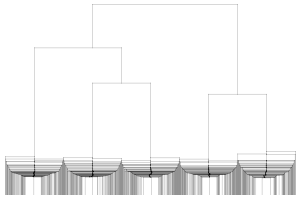

In [3]:
plotly_dendrogram(dendrogram, min_size=50, line_width=.6, width=300, height=200, largest_left=False)

Initializing:   0%|          | 0/1000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/999 [00:00<?, ?it/s]

Drawing lines:   0%|          | 0/3839 [00:00<?, ?it/s]

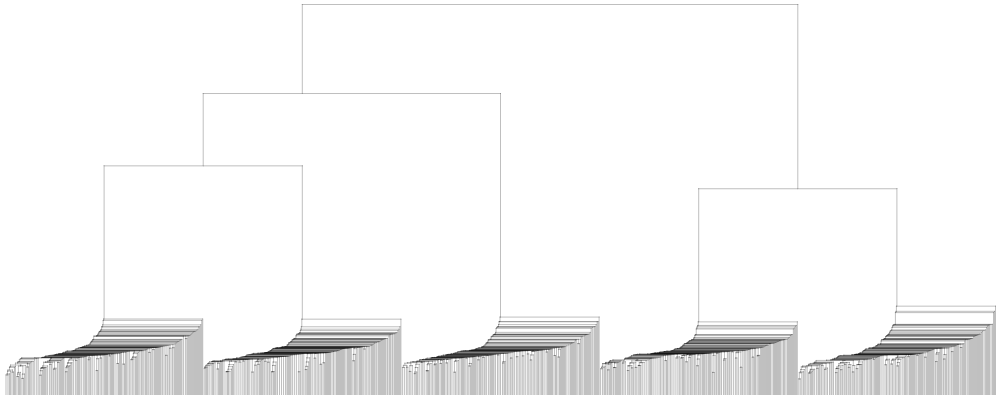

In [4]:
dendrogram = HSSL_Turbo(X, cuda=False, n_trees=10, max_leaf_size=20)
plotly_dendrogram(dendrogram, min_size=2)

Initializing:   0%|          | 0/2000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/1999 [00:00<?, ?it/s]

Drawing lines:   0%|          | 0/8114 [00:00<?, ?it/s]

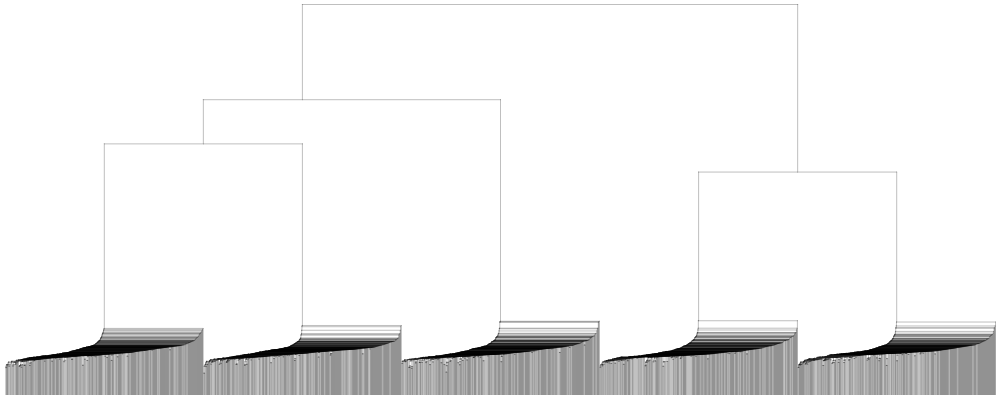

In [5]:
### HSSL_Turbo run ###
np.random.seed(0)
nX, large_d, d = 2_000, 10, 10
X = make_blobs(nX, d, centers=5, random_state=42)[0].astype(np.float32)
if large_d != d:
    rot = np.linalg.eigh(np.cov(np.random.normal(0,1,(large_d, large_d))))[1].astype(np.float32)
    X = X.dot(rot[:d,:])
dendrogram = HSSL_Turbo(X, cuda=False, n_trees=10, max_leaf_size=20)
plotly_dendrogram(dendrogram, min_size=2)

In [6]:
def ensure_folder_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created folder: {path}")
    else:
        print(f"Folder already exists: {path}")

In [21]:
def run_program(algo, dataset_path, model_kwargs):

    with h5py.File(dataset_path, "r") as f:
        data = f['data'][:]

    if algo == "HNSW_HSSL":

        time_start = time.time()
        dendrogram = HNSW_HSSL(data.astype(np.float32), **model_kwargs)
        time_end = time.time()
        total_time = time_end - time_start

    elif algo == "HSSL_Turbo":
        
        time_start = time.time()
        dendrogram = HSSL_Turbo(data, **model_kwargs)
        time_end = time.time()
        total_time = time_end - time_start
    
    else:
        print(f"ERROR - algorithm not supported, available algorithms are: \n HSSL_Turbo, HNSW_HSSL ")
        return
    
    ensure_folder_exists("results/" + dataset_path.split(".hdf5")[0].split("/")[1] + "/" + algo)
    with h5py.File("results/" + dataset_path.split(".hdf5")[0].split("/")[1] + "/" + algo + "/dendro.hdf5", "w") as f:
        f.create_dataset("dendrogram_data", data=dendrogram)
        f.create_dataset("time", data=[total_time])
        f.create_dataset("n", data=[len(data)])
        f.create_dataset("algo", data=[algo])
        # f.create_dataset("params", data=[model_kwargs])

In [22]:
import json

hnsw_args = json.loads("""
{
    "defaults": {
        "max_build_heap_size": 100,
        "higher_max_degree": 20
    },
    "runs": [
        {},
        {
            "max_build_heap_size": 10,
            "higher_max_degree": 10
        },
        {
            "higher_max_degree": 10
        }
    ]
}
""")

defaults = hnsw_args["defaults"]
runs = hnsw_args["runs"]

print(defaults, runs)

# for i, run in enumerate(runs):
#    print(f"Running config {i+1}...")

#    # Merge default and override
#    hnsw_kwargs = {**defaults, **run}
#    print(hnsw_kwargs)

datasets = ["blobs_n=2000_centers=5.hdf5",
            "blobs_n=4000_centers=5.hdf5", 
            # "blobs_n=8000_centers=5.hdf5",
            # "blobs_n=16000_centers=5.hdf5", 
            # "blobs_n=32000_centers=5.hdf5",
            # "blobs_n=64000_centers=5.hdf5",
            # "blobs_n=128000_centers=5.hdf5",
            # "cancer.hdf5",
            # "iris.hdf5",
            # "wine.hdf5",
            # "mnist.hdf5"
            ]

for dataset in datasets:
    for run in runs:
        hnsw_kwargs = {**defaults, **run}

        run_program("HNSW_HSSL", "datasets/" + dataset, hnsw_kwargs)

{'max_build_heap_size': 100, 'higher_max_degree': 20} [{}, {'max_build_heap_size': 10, 'higher_max_degree': 10}, {'higher_max_degree': 10}]


Initializing:   0%|          | 0/2000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/1999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=2000_centers=5/HNSW_HSSL


Initializing:   0%|          | 0/2000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/1999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=2000_centers=5/HNSW_HSSL


Initializing:   0%|          | 0/2000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/1999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=2000_centers=5/HNSW_HSSL


Initializing:   0%|          | 0/4000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/3999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=4000_centers=5/HNSW_HSSL


Initializing:   0%|          | 0/4000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/3999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=4000_centers=5/HNSW_HSSL


Initializing:   0%|          | 0/4000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/3999 [00:00<?, ?it/s]

Folder already exists: results/blobs_n=4000_centers=5/HNSW_HSSL


In [ ]:
for dataset in datasets:
    run_program("HSSL_Turbo", "datasets/" + dataset)

Initializing:   0%|          | 0/4000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/3999 [00:00<?, ?it/s]

Created folder: results/blobs_n=4000_centers=5/HSSL_Turbo


Initializing:   0%|          | 0/16000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/15999 [00:00<?, ?it/s]

Created folder: results/blobs_n=16000_centers=5/HSSL_Turbo


Initializing:   0%|          | 0/64000 [00:00<?, ?it/s]

Merging clusters:   0%|          | 0/63999 [00:00<?, ?it/s]

In [ ]:
import json

all_my_args = json.loads("""
{
    "defaults": {
        "ef": 100,
        "M": 20
    },
    "runs": [
        {},
        {
            "ef": 10,
            "M": 10
        },
        {
            "M": 10
        }
    ]
}
""")

print(all_my_args)

defaults = all_my_args["defaults"]
runs = all_my_args["runs"]

print(defaults, runs)

for i, run in enumerate(runs):
    print(f"Running config {i+1}...")

    # Override defaults with values from runs
    hnsw_kwargs = {**defaults, **run}
    print(hnsw_kwargs)

path = 'datasets/blobs_n=2000_centers=5.hdf5'

with h5py.File(path, 'r') as f:
    X = f['data'][:]

# dendrogram = HNSW_HSSL(X.astype(np.float32))
# den = HNSW_HSSL(X, **hnsw_kwargs)